<a href="https://colab.research.google.com/github/getiyern/colabtools/blob/main/DiffEq_Workflow_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95
 1.96 

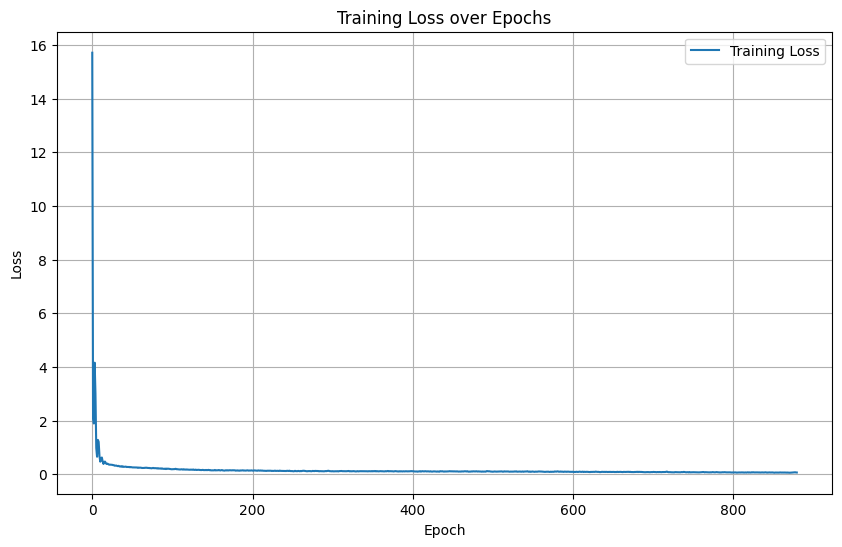

In [16]:
!pip install torcheval
import torch
from torch import nn
from torcheval.metrics.regression import R2Score
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

from sklearn.preprocessing import StandardScaler
import math

from sklearn.model_selection import train_test_split

import pandas as pd


#Solving df/dx= F(x,f(x), df/dx)  with initial condition, f(0)=f0, therefore trial solution is
#Trial Solution= x*N(x)+f0 for first order ODE and x^2*N(x)+df_d0+f0 for 2nd order ODE,  where N is the output of final objective Neural Network

g = 9.8

L= 1

f0= 0 #Initial condition

df_d0 = 1 #Initial first derivative for 2nd order ODE


x= np.arange(0,10,0.01) #Define domain points to solve diff eq at
print(x)

# Convert x to Tensor for Pytorch and enable gradient computation
x_tensor = torch.from_numpy(x).float().unsqueeze(1).requires_grad_(True)
train_dataset = TensorDataset(x_tensor)
train_loader = DataLoader(train_dataset, batch_size=445, shuffle=True)


device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")


#Define the Neural Network 'N'
class NeuralNetwork(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.fc1= nn.Linear(in_features=input_features, out_features=149)
        self.relu= nn.ReLU()
        self.fc3= nn.Linear(in_features=149, out_features=1)

    def forward(self, x):
        x= self.fc1(x)
        x= self.relu(x)
        x= self.fc3(x)
        return x


# We will use a single network (modelf) as our N(x)
modelf= NeuralNetwork(input_features=1)


# Loss function based on the differential equation
class PDESpecificLoss(nn.Module):
    def __init__(self):
        super(PDESpecificLoss, self).__init__()

    def forward(self, f_predicted, df_dx_predicted, df2_dx_predicted, x):

        loss = (df2_dx_predicted+torch.sin(x))**2  #f_predicted)/L)**2    #(torch.tan(torch.exp(x))))**2#+torch.cos(x)*f_predicted-torch.sin(x)*torch.exp(-x))**2 #Solving d^2f/dx^2= -f(x) but torch.tan(x)**0.5
        #can modify loss to solve any 1st or 2nd order ODE

        return torch.mean(loss) # Using mean loss over the batch

loss_fn = PDESpecificLoss()
optimizer = torch.optim.Adam(modelf.parameters(), lr= 0.0008)

# Training function using automatic differentiation
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, Z_list in enumerate(dataloader):
        Z = Z_list[0] # Z is already a tensor with requires_grad=True

        # Calculate the trial solution f_trial = x^2*N(x)+ x*df_d0+ f0
        # model(Z) is N(Z)
        N_output = model(Z)
        f_trial= Z**2*N_output+ Z*df_d0+ f0  #*df_d0+ f0

        # Calculate the derivative of the trial solution with respect to Z using autograd
        # This computes df_trial/dZ
        df_trial_dZ = torch.autograd.grad(
            f_trial, Z,
            grad_outputs=torch.ones_like(f_trial), # Gradient of the output (f_trial) with respect to itself
            create_graph=True, # Needed to compute higher-order derivatives if necessary, good practice for PINNs
            retain_graph=True # Retain graph for second derivative calculation
        )[0] # torch.autograd.grad returns a tuple, we need the first element
        df2_trial_dZ = torch.autograd.grad(
            df_trial_dZ, Z,
            grad_outputs=torch.ones_like(df_trial_dZ), # Gradient of the output (f_trial) with respect to itself
            create_graph=True # Needed to compute higher-order derivatives if necessary, good practice for PINNs
        )[0] # torch.autograd.grad returns a tuple, we need the first element

        current_loss = loss_fn(f_trial, df_trial_dZ,df2_trial_dZ, Z)

        # Backpropagation
        current_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += current_loss.item()

        if batch % 100 == 0:
            loss_val, current = current_loss.item(), (batch + 1) * len(Z[0])
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / len(dataloader)
    return avg_loss


epochs = 880 # Increased epochs for potentially better convergence
loss_history = [] # List to store loss values for plotting

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_loss = train(train_loader, modelf, loss_fn, optimizer)
    loss_history.append(epoch_loss)

print("Done!")

#print('Final Neural Network output N(x) below!')
#print(modelf(x_tensor).detach().numpy())

# Plotting the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

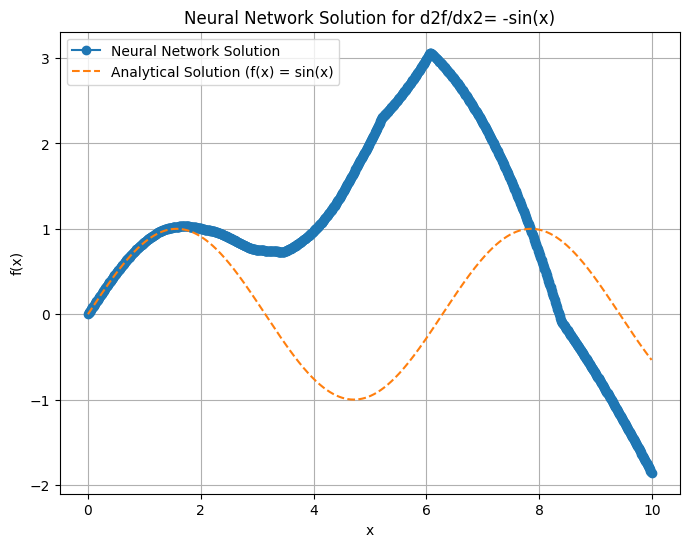

MSE=  2.702845850077567


In [17]:
# Get the model's output for the input values x

#from scipy.stats import norm

with torch.no_grad():
    predicted_f = modelf(torch.from_numpy(x).float().unsqueeze(1)).squeeze().numpy()*(x**2)+ df_d0*x+ f0


analytical_f = np.sin(x) # x**3/3+3*x**2/2+2*x+1  # 0.5*np.exp(x)*(np.sin(x)-np.cos(x))+0.5 #(1-np.cos(x))*np.exp(-np.sin(x))#np.sin(x) #-2*x*np.exp(-x)+2*x# 10*x**2#np.cos(x)+np.sin(x)# (-4*np.sin(3)-np.cos(3))*np.cos(x)+ (4*np.cos(3)-np.sin(3))*np.sin(x)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(x, predicted_f, label='Neural Network Solution', marker='o')
plt.plot(x, analytical_f, label='Analytical Solution (f(x) = sin(x)', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Neural Network Solution for d2f/dx2= -sin(x)')
plt.legend()
plt.grid(True)
plt.show()

mse=0

for i in range(len(x)):
  mse+= (predicted_f[i]-analytical_f[i])**2

mse=mse/len(x)

print("MSE= ", mse)

#print("Predicted Integral", predicted_f[-1]-predicted_f[0])

#mse= (0.83-(predicted_f[-1]-predicted_f[0]))**2/2

#print('mse=', mse)


In [15]:
#Using Optuna Library to optimize hyperparameters and refine prediction
!pip install optuna
import optuna
def objective(trial, input_features, device, train_dataloader, loss_fn, train_fn):
  # You can define hyperparameters to optimize here, for example:
  learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
  epochs = trial.suggest_int("epochs", 10, 1000)
  hidden_layer_1_size = trial.suggest_int("hidden_layer_1_size", 10, 1000)
  batch_size = trial.suggest_int("batch_size", 50, len(train_dataloader.dataset)) # Suggest batch size

  # Recreate the model with suggested hyperparameters
  model = NeuralNetwork(input_features=1).to(device) # Pass integer for input features
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Create new dataloaders with the suggested batch size
  train_dataset_optuna = TensorDataset(train_dataloader.dataset.tensors[0])
  #test_dataset_optuna = TensorDataset(test_dataloader.dataset.tensors[0], test_dataloader.dataset.tensors[1])
  train_dataloader_optuna = DataLoader(train_dataset_optuna, batch_size=batch_size)
  #test_dataloader_optuna = DataLoader(test_dataset_optuna, batch_size=batch_size)

  final_loss = 0
  # Train the model and get both training and test loss histories
  for t in range(epochs):
      #print(f"Epoch {t+1}\n-------------------------------") # Commented out to reduce output verbosity during optimization
      final_loss = train_fn(train_dataloader_optuna, model, loss_fn, optimizer)

  # Optuna tries to minimize the objective, so return the final loss
  return final_loss

# Modify train function to return epoch_loss instead of total_loss
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, Z_list in enumerate(dataloader):
        Z = Z_list[0] # Z is already a tensor with requires_grad=True

        # Calculate the trial solution f_trial = x^2*N(x)+ x*df_d0+ f0
        # model(Z) is N(Z)
        N_output = model(Z)
        f_trial = Z**2*N_output+ Z*df_d0+ f0

        # Calculate the derivative of the trial solution with respect to Z using autograd
        # This computes df_trial/dZ
        df_trial_dZ = torch.autograd.grad(
            f_trial, Z,
            grad_outputs=torch.ones_like(f_trial), # Gradient of the output (f_trial) with respect to itself
            create_graph=True # Needed to compute higher-order derivatives if necessary, good practice for PINNs
        )[0] # torch.autograd.grad returns a tuple, we need the first element
        df2_trial_dZ = torch.autograd.grad(
            df_trial_dZ, Z,
            grad_outputs=torch.ones_like(df_trial_dZ), # Gradient of the output (f_trial) with respect to itself
            create_graph=True # Needed to compute higher-order derivatives if necessary, good practice for PINNs
        )[0] # torch.autograd.grad returns a tuple, we need the first element


        current_loss = loss_fn(f_trial, df_trial_dZ,df2_trial_dZ, Z)

        # Backpropagation
        current_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += current_loss.item()

        # if batch % 100 == 0: # Commented out to reduce output verbosity during optimization
        #     loss_val, current = current_loss.item(), (batch + 1) * len(Z[0])
        #     print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / len(dataloader)
    return avg_loss




study = optuna.create_study(direction="minimize")

# Optimize the objective function
study.optimize(lambda trial: objective(trial, x_tensor, device, train_loader, loss_fn, train), n_trials= 10)

print(study.best_params)
print(study.best_value)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.5 MB/s eta 0:00:00


[I 2025-11-12 00:54:32,307] A new study created in memory with name: no-name-c5464042-24b1-4a25-aba6-d862b73c2808
[I 2025-11-12 00:56:23,525] Trial 0 finished with value: 0.05988913285546005 and parameters: {'learning_rate': 0.0001019266051329561, 'epochs': 656, 'hidden_layer_1_size': 904, 'batch_size': 422}. Best is trial 0 with value: 0.05988913285546005.
[I 2025-11-12 00:57:12,709] Trial 1 finished with value: 0.06962977908551693 and parameters: {'learning_rate': 0.0007359885193964861, 'epochs': 294, 'hidden_layer_1_size': 676, 'batch_size': 728}. Best is trial 0 with value: 0.05988913285546005.
[I 2025-11-12 00:59:02,535] Trial 2 finished with value: 0.4467582110315561 and parameters: {'learning_rate': 0.05944133533545963, 'epochs': 637, 'hidden_layer_1_size': 77, 'batch_size': 229}. Best is trial 0 with value: 0.05988913285546005.
[I 2025-11-12 01:01:24,208] Trial 3 finished with value: 183.96172484755516 and parameters: {'learning_rate': 0.0007115509355618119, 'epochs': 811, 'hid

{'learning_rate': 0.0008721859751701429, 'epochs': 880, 'hidden_layer_1_size': 149, 'batch_size': 445}
0.03223026202370723
